### 1. Get cutouts of CH3CN ladders from our data

In [2]:
# For parallelization, which helps to make convolution faster
import dask
dask.config.set(scheduler = 'threads', num_workers = 8)
from dask.diagnostics import ProgressBar
ProgressBar().register()
import warnings
warnings.filterwarnings('ignore')

In [3]:
from astropy import units as u

results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'

# J = 5 - 4
freq_spw_05_04 = '93_spw27'
# fmin_05_04 = 91.958*u.GHz
# fmax_05_04 = 91.988*u.GHz

# # J = 7 - 6
# freq_spw_07_06 = '129_spw67'
# fmin_07_06 = 128.690*u.GHz
# fmax_07_06 = 128.780*u.GHz

# J = 8 - 7
freq_spw_08_07 = '146_spw51'
# fmin_08_07 = 147.035*u.GHz
# fmax_08_07 = 147.175*u.GHz

# J = 14 - 13
freq_spw_14_13 = '257_spw45'
# fmin_14_13 = 255.309*u.GHz
# fmax_14_13 = 257.182*u.GHz

In [4]:
from spectral_cube import SpectralCube

cube_05_04 = SpectralCube.read(results+'source_ab_'+freq_spw_05_04+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image', use_dask = True).to(u.K)
# cube_07_06 = SpectralCube.read(results+'source_ab_'+freq_spw_07_06+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image', use_dask = True).to(u.K)
cube_08_07 = SpectralCube.read(results+'source_ab_'+freq_spw_08_07+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image', use_dask = True).to(u.K)
cube_14_13 = SpectralCube.read(results+'source_ab_'+freq_spw_14_13+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image', use_dask = True).to(u.K)
cube_05_04, cube_08_07, cube_14_13

(DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=K and chunk size (80, 256, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 91425792724.639 Hz:93299566513.404 Hz,
 DaskVaryingResolutionSpectralCube with shape=(3840, 512, 512) and unit=K and chunk size (128, 256, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 145582599820.702 Hz:147457166014.871 Hz,
 DaskVaryingResolutionSpectralCube with shape=(3840, 512, 512) and unit=K and chunk size (128, 256, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    

In [5]:
ch3cn_cubes = [cube_05_04, cube_08_07, cube_14_13]

In [6]:
import numpy as np

# Get cutout of methyl cyanide ladder
ch3cn_subcubes = []
for cube in ch3cn_cubes:
    ch3cn_tbl = cube.find_lines(chemical_name = 'CH3CN', line_lists = ['JPL'], 
                               show_upper_degeneracy = True, show_qn_code = True)
    ch3cn_tbl = ch3cn_tbl[ch3cn_tbl['Quantum Number Code'] == 202]
    min_freq = (np.min(ch3cn_tbl['Freq-GHz(rest frame,redshifted)']) - 0.05)*u.GHz
    max_freq = (np.max(ch3cn_tbl['Freq-GHz(rest frame,redshifted)']) + 0.05)*u.GHz
#     print(min_freq, max_freq)
    subcube = cube.spectral_slab(min_freq, max_freq)
    ch3cn_subcubes.append(subcube)
ch3cn_subcubes

[DaskVaryingResolutionSpectralCube with shape=(132, 512, 512) and unit=K and chunk size (67, 256, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:    132  type_s: FREQ      unit_s: Hz     range: 91909126766.035 Hz:92037039411.334 Hz,
 DaskVaryingResolutionSpectralCube with shape=(490, 512, 512) and unit=K and chunk size (128, 256, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:    490  type_s: FREQ      unit_s: Hz     range: 146985960915.269 Hz:147224737385.430 Hz,
 DaskVaryingResolutionSpectralCube with shape=(1092, 512, 512) and unit=K and chunk size (128, 256, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    ra

### 2. Convert all cubes to a common beam

In [7]:
smoothed_ch3cn_subcubes = []
for cube in ch3cn_subcubes:
    cube_common_beam = cube.beams.common_beam(max_iter = 20, max_epsilon = 0.01)
    smoothed_cube = cube.convolve_to(cube_common_beam) # Convert from VaryingResolution to regular
    smoothed_ch3cn_subcubes.append(smoothed_cube)

import radio_beam

beams = []
for cube in smoothed_ch3cn_subcubes:
    beams.append(cube.beam)

common_beam = radio_beam.commonbeam.common_manybeams_mve(radio_beam.Beams(beams = beams)) # Get common beam between all cubes
common_beam

Beam: BMAJ=1.5285954351598425 arcsec BMIN=1.2568141723437132 arcsec BPA=104.37171324679557 deg

In [8]:
resampled_ch3cn_subcubes = []
for cube in smoothed_ch3cn_subcubes:
    resampled_cube = cube.convolve_to(common_beam) # This cell takes almost no time; the cubes do not get convolved in this step
    resampled_ch3cn_subcubes.append(resampled_cube)
resampled_ch3cn_subcubes

[DaskSpectralCube with shape=(132, 512, 512) and unit=K and chunk size (64, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:    132  type_s: FREQ      unit_s: Hz     range: 91909126766.035 Hz:92037039411.334 Hz,
 DaskSpectralCube with shape=(490, 512, 512) and unit=K and chunk size (64, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:    490  type_s: FREQ      unit_s: Hz     range: 146985960915.269 Hz:147224737385.430 Hz,
 DaskSpectralCube with shape=(1092, 512, 512) and unit=K and chunk size (64, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:   1092 

### 3. Plot our data on these ladders

The first cell here is TEMPORARY, and should be removed after we reinstate step 2 above.

In [9]:
# resampled_ch3cn_subcubes = ch3cn_subcubes

In [10]:
# Extract spectrum for brightest pixel in central core region
import regions
reg = regions.Regions.read('/blue/adamginsburg/abulatek/brick/first_results/region_temperatures/centralcoreellipse.reg')

resampled_ch3cn_subcubes_reg = []
for cube in resampled_ch3cn_subcubes:
    resampled_cube_reg = cube.subcube_from_regions(reg)
    resampled_ch3cn_subcubes_reg.append(resampled_cube_reg)
resampled_ch3cn_subcubes_reg

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.7s


[DaskSpectralCube with shape=(132, 17, 17) and unit=K and chunk size (64, 17, 17):
  n_x:     17  type_x: RA---SIN  unit_x: deg    range:   266.543777 deg:  266.544790 deg
  n_y:     17  type_y: DEC--SIN  unit_y: deg    range:   -28.705319 deg:  -28.704431 deg
  n_s:    132  type_s: FREQ      unit_s: Hz     range: 91909126766.035 Hz:92037039411.334 Hz,
 DaskSpectralCube with shape=(490, 17, 17) and unit=K and chunk size (64, 17, 17):
  n_x:     17  type_x: RA---SIN  unit_x: deg    range:   266.543777 deg:  266.544790 deg
  n_y:     17  type_y: DEC--SIN  unit_y: deg    range:   -28.705319 deg:  -28.704431 deg
  n_s:    490  type_s: FREQ      unit_s: Hz     range: 146985960915.269 Hz:147224737385.430 Hz,
 DaskSpectralCube with shape=(1092, 17, 17) and unit=K and chunk size (64, 17, 17):
  n_x:     17  type_x: RA---SIN  unit_x: deg    range:   266.543777 deg:  266.544790 deg
  n_y:     17  type_y: DEC--SIN  unit_y: deg    range:   -28.705319 deg:  -28.704431 deg
  n_s:   1092  type_s: FRE

In [11]:
max_spectra = []
for cube in resampled_ch3cn_subcubes_reg:
    # Get the moment 0 map for the cube
    m0 = cube.moment0()
    
    brightest_pixel = np.unravel_index(np.nanargmax(m0), m0.shape)
    spec_for_max_pixel = cube[:, brightest_pixel[0], brightest_pixel[1]]
    max_spectra.append(spec_for_max_pixel)
    print("Finished with a spectrum!")

[########################################] | 100% Completed | 54.5s
[########################################] | 100% Completed | 53.3s
[########################################] | 100% Completed | 53.4s
Finished with a spectrum!
[########################################] | 100% Completed |  2min 10.2s
[########################################] | 100% Completed |  2min  9.4s
[########################################] | 100% Completed |  2min  9.9s
Finished with a spectrum!
[########################################] | 100% Completed |  6min 29.4s
[########################################] | 100% Completed |  6min 26.3s
[########################################] | 100% Completed |  6min 22.5s
Finished with a spectrum!


In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 15))

for ind, (cube, spectrum) in enumerate(zip(resampled_ch3cn_subcubes, max_spectra)):
    ax = plt.subplot(3, 3, ind + 1)
    ax.plot(cube.spectral_axis.to(u.GHz), np.array(spectrum), linestyle = '-', color = 'k', linewidth = 0.5, drawstyle = 'steps-mid')
    ax.set_xlabel(f"Frequency [{resampled_ch3cn_subcubes_reg[0].spectral_axis.to(u.GHz).unit}]")
    ax.set_ylabel(f"Brightness Temperature [{max_spectra[0].unit}]")

### 4. Generate XCLASS models of those same ladders

In [13]:
# Get path of XCLASS directory
import os
import sys
XCLASSRootDir = str(os.environ.get('XCLASSRootDir', '')).strip()
XCLASSRootDir = os.path.normpath(XCLASSRootDir) + "/"

# Extend sys.path variable
NewPath = XCLASSRootDir + "build_tasks/"
if (not NewPath in sys.path):
    sys.path.append(NewPath)

import task_myXCLASS

In [14]:
source_size =  4.3350376922e+00
tkin = 153.1 # 7.9842254347e+01
Ntot = 1.5e+14 # 10**N_tot # 1.5061155735e+14 # 1.0061155735e+16
vwidth_fwhm = 4.2101396644e+00
vwidth = vwidth_fwhm / np.sqrt(8*np.log(2))
vcen = 38.0
tbg = 0

In [15]:
import sys
import os
# Define path and name of molfit file
# DEFAULT MolfitsFileName = LocalPath + "files/my_molecules.molfit"
LocalPath = os.getcwd() + "/"

MolfitsFileName = LocalPath + 'CH3CN_pure.molfit'

def set_xclass_parameters(source_size=source_size, tkin=tkin, Ntot=Ntot, vwidth_fwhm=vwidth_fwhm, vcen=vcen, filename=MolfitsFileName):
    with open(filename, "w") as fh:
        fh.write(f"""
%============================================================================================================================
%
% define molecules and their components:
%
%============================================================================================================================
%    source size:                 T_kin:               N_tot:            V_width:                V_off:   CFFlag:    keyword:
%       [arcsec]:                   [K]:              [cm-2]:            [km /s]:              [km /s]:       []:         []:
CH3CN;v=0;           1
 {source_size}       {tkin}     {Ntot}     {vwidth_fwhm}    {vcen}         c
""")

In [16]:
# define freq. step (in MHz)
FreqStep = 0.1

# depending on parameter "Inter_Flag" define beam size (in arcsec)
# (Inter_Flag = True) or size of telescope (in m) (Inter_Flag = False)
TelescopeSize = 1000.0 # meters

# define beam minor axis length (in arsec)
BMIN = None

# define beam major axis length (in arsec)
BMAJ = None

# define beam position angle (in degree)
BPA = None

# interferrometric data?
Inter_Flag = False

# define red shift
Redshift = None

# BACKGROUND: describe continuum with tBack and tslope only
t_back_flag = True

# BACKGROUND: define background temperature (in K)
tBack = 0.0

# BACKGROUND: define temperature slope (dimensionless)
tslope = 0.0

# BACKGROUND: define path and name of ASCII file describing continuum as function
#             of frequency
BackgroundFileName = ""

# DUST: define hydrogen column density (in cm^(-2))
N_H = 1.e22

# DUST: define spectral index for dust (dimensionless)
beta_dust = 0.0

# DUST: define kappa at 1.3 mm (cm^(2) g^(-1))
kappa_1300 = 0.0

# DUST: define path and name of ASCII file describing dust opacity as
#       function of frequency
DustFileName = ""

# FREE-FREE: define electronic temperature (in K)
Te_ff = None

# FREE-FREE: define emission measure (in pc cm^(-6))
EM_ff = None

# SYNCHROTRON: define kappa of energy spectrum of electrons (electrons m^(−3) GeV^(-1))
kappa_sync = None

# SYNCHROTRON: define magnetic field (in Gauss)
B_sync = None

# SYNCHROTRON: energy spectral index (dimensionless)
p_sync = None

# SYNCHROTRON: thickness of slab (in AU)
l_sync = None

# PHEN-CONT: define phenomenological function which is used to describe
#            the continuum
ContPhenFuncID = None

# PHEN-CONT: define first parameter for phenomenological function
ContPhenFuncParam1 = None

# PHEN-CONT: define second parameter for phenomenological function
ContPhenFuncParam2 = None

# PHEN-CONT: define third parameter for phenomenological function
ContPhenFuncParam3 = None

# PHEN-CONT: define fourth parameter for phenomenological function
ContPhenFuncParam4 = None

# PHEN-CONT: define fifth parameter for phenomenological function
ContPhenFuncParam5 = None

# use iso ratio file?
iso_flag = True

# define path and name of iso ratio file
#DEFAULT IsoTableFileName = LocalPath + "files/my_isonames.txt"
IsoTableFileName = LocalPath + "my_isonames.txt"

# define path and name of file describing Non-LTE parameters
CollisionFileName = ""

# define number of pixels in x-direction (used for sub-beam description)
NumModelPixelXX = 100

# define number of pixels in y-direction (used for sub-beam description)
NumModelPixelYY = 100

# take local-overlap into account or not
LocalOverlapFlag = False

# disable sub-beam description
NoSubBeamFlag = True

# define path and name of database file
dbFilename = ""

# define rest freq. (in MHz)
RestFreq = 0.0

# define v_lsr (in km/s)
vLSR = 0.0

In [17]:
import io
from contextlib import redirect_stdout

def myxclass_call(FreqMin=1e3, FreqMax=1e4, verbose=False):
    ## call myXCLASS function
    with io.StringIO() as buf, redirect_stdout(buf):
        modeldata, log, TransEnergies, IntOpt, JobDir = task_myXCLASS.myXCLASS(
                                                    FreqMin, FreqMax, FreqStep,
                                                    TelescopeSize, BMIN, BMAJ,
                                                    BPA, Inter_Flag, Redshift,
                                                    t_back_flag, tBack, tslope,
                                                    BackgroundFileName,
                                                    N_H, beta_dust, kappa_1300,
                                                    DustFileName, Te_ff, EM_ff,
                                                    kappa_sync, B_sync, p_sync,
                                                    l_sync, ContPhenFuncID,
                                                    ContPhenFuncParam1,
                                                    ContPhenFuncParam2,
                                                    ContPhenFuncParam3,
                                                    ContPhenFuncParam4,
                                                    ContPhenFuncParam5,
                                                    MolfitsFileName, iso_flag,
                                                    IsoTableFileName,
                                                    CollisionFileName,
                                                    NumModelPixelXX,
                                                    NumModelPixelYY,
                                                    LocalOverlapFlag,
                                                    NoSubBeamFlag,
                                                    dbFilename,
                                                    RestFreq, vLSR)
        output = buf.getvalue()
    if verbose:
        print(output)
        
    return modeldata, log, TransEnergies, IntOpt, JobDir

In [18]:
modeldatas = []
for spectrum in max_spectra:
    # define min. freq. (in MHz)
    FreqMin = np.min(spectrum.spectral_axis.to(u.MHz)).value
    # define max. freq. (in MHz)
    FreqMax = np.max(spectrum.spectral_axis.to(u.MHz)).value

    set_xclass_parameters()
    modeldata, log, TransEnergies, IntOpt, JobDir = myxclass_call(FreqMin=FreqMin, FreqMax=FreqMax)
    modeldatas.append(modeldata)

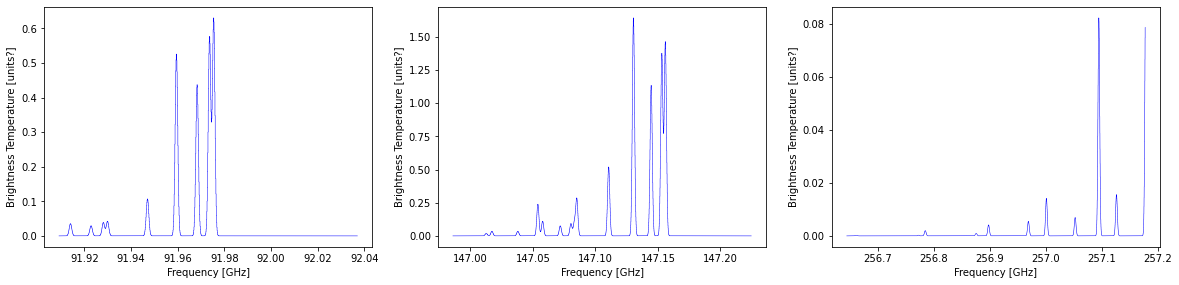

In [19]:
fig = plt.figure(figsize = (20, 15))

for ind, modeldata in enumerate(modeldatas):
    ax = plt.subplot(3, 3, ind + 1)
    ax.plot((modeldata[:,0]*u.MHz).to(u.GHz), modeldata[:,1], linestyle = '-', color = 'b', linewidth = 0.5, drawstyle = 'steps-mid')
    ax.set_xlabel(f"Frequency [{(modeldata[:,0]*u.MHz).to(u.GHz).unit}]")
    ax.set_ylabel(f"Brightness Temperature [units?]")

### 5. Overplot our data and the XCLASS models

In [20]:
# Preliminary continuum subtraction
max_spectra_contsub = []
for spectrum in max_spectra:
    spectrum_contsub = np.array(spectrum) - np.median(np.array(spectrum))
    max_spectra_contsub.append(spectrum_contsub)

In [26]:
SM_SIZE = 12
MD_SIZE = 14
LG_SIZE = 20

plt.rc('font', size = MD_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = LG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = MD_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = SM_SIZE)    # legend fontsize
plt.rc('figure', titlesize = LG_SIZE)   # fontsize of the figure title

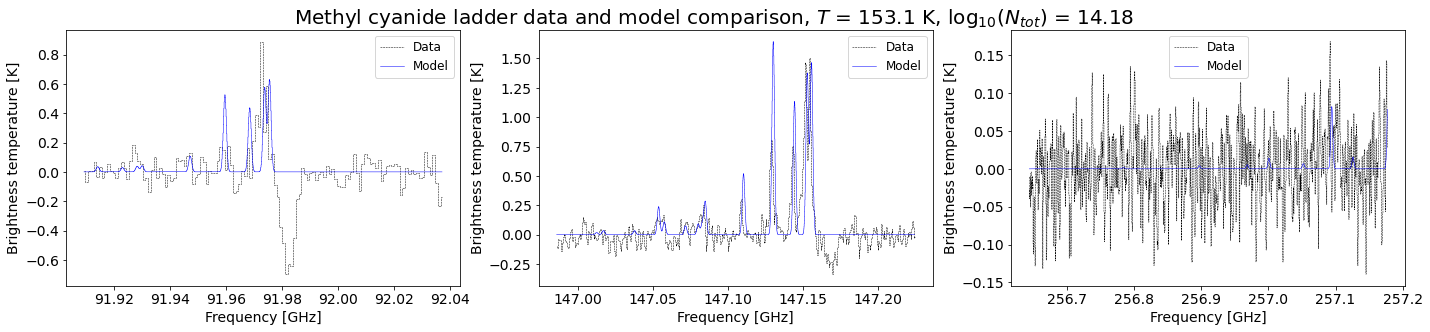

In [30]:
fig = plt.figure(figsize = (24, 16))

for ind, (cube, spectrum, modeldata) in enumerate(zip(resampled_ch3cn_subcubes, max_spectra_contsub, modeldatas)):
    ax = plt.subplot(3, 3, ind + 1)
    ax.plot(cube.spectral_axis.to(u.GHz), spectrum, linestyle = '--', color = 'k', linewidth = 0.5, drawstyle = 'steps-mid', 
            label = "Data")
    ax.plot((modeldata[:,0]*u.MHz).to(u.GHz), modeldata[:,1], linestyle = '-', color = 'b', linewidth = 0.5, drawstyle = 'steps-mid', 
            label = "Model")
    plt.legend(loc='best')
    ax.set_xlabel(f"Frequency [{cube.spectral_axis.to(u.GHz).unit}]")
    ax.set_ylabel(f"Brightness temperature [{cube.unit}]")
plt.suptitle(f"Methyl cyanide ladder data and model comparison, $T$ = {tkin:.1f} K, $\log_{{10}}(N_{{tot}})$ = {np.log10(Ntot):.2f}", y = 0.9)
plt.savefig('/blue/adamginsburg/abulatek/brick/first_results/figures/methyl_cyanide_XCLASS_comparison.png', bbox_inches = 'tight', overwrite = True)